In [2]:
from __future__ import division
import os
from os.path import join
import numpy as np
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# paths to subject dir
subj = '13034'
dataDir = '../data'

## Prepare the attributes
Prepare a set of volume labels that can be used to slice the dataset up for different
analyses with PyMVPA. There needs to be one label per volume, but there can be multiple different 
labels assigned to the same volume. 

In [4]:
# read trialOnsets file
trialOnsets = pd.read_table(join(dataDir, subj, (subj + '_trialOnsets.txt')))
trialOnsets.head()

,TrialOnset,Modality,Category,Stimulus
0,2000,Word,dwelling,castle
1,11995,Word,tool,saw
2,22007,Word,dwelling,house
3,32002,Word,dwelling,tent
4,41980,Word,tool,screwdriver


In [26]:
trialOnsets.TrialOnset

0       2000
1      11995
2      22007
3      32002
4      41980
5      51992
6      61987
7      71998
8      81993
9      91988
10    102000
11    111995
12    121990
13    132002
14    141997
15    151992
16    161987
17    171999
18    181994
19    192005
20    202000
21    211995
22    221990
23    232002
24    262004
25    271999
26    282010
27    292005
28    302000
29    311995
30    322007
31    332002
32    342014
33    352009
34    362004
35    371999
36    382011
37    392006
38    401984
39    412012
40    422007
41    432002
42    441997
43    452009
44    462004
45    471999
46    482011
47    492006
Name: TrialOnset, dtype: int64

In [5]:
# function to convert trial onsets into volume labels
def makeAttributes(trialOnsets):
    """
    Make an attributes table that labels every volume in the run according 
    to the different ways of sorting these stimuli (e.g. words vs pics, etc...)
    """
    # number of timepts to label
    nVols = 500
    volsPerTrial = 3  # how long was each trial (in volumes)
    
    # create a list with dummy values for every volume
    blankVolLabels = ['n'] * nVols
    
    ### make the copies for each category
    modLabels = blankVolLabels[:]
    catLabels = blankVolLabels[:]
    stimLabels = blankVolLabels[:]
    
    # loop over each trial in trialOnsets
    for i,row in trialOnsets.iterrows():
        # convert onset time to nearest vol index
        onset = int(np.round(row['TrialOnset']/1000))
        
        # update the labels, starting at onset, continuing through however many volsPerTrial
        modLabels[onset:(onset+volsPerTrial)] = [row['Modality']] * volsPerTrial
        catLabels[onset:(onset+volsPerTrial)] = [row['Category']] * volsPerTrial
        stimLabels[onset:(onset+volsPerTrial)] = [row['Stimulus']] * volsPerTrial
        
    # convert to a dataframe
    attributes_df = pd.DataFrame({'modality':modLabels, 'category':catLabels, 'stimulus':stimLabels})
    return attributes_df


In [6]:
# create the table of volume labels for this subject
attributes = makeAttributes(trialOnsets)

In [7]:
attributes.head()

,category,modality,stimulus
0,n,n,n
1,n,n,n
2,dwelling,Word,castle
3,dwelling,Word,castle
4,dwelling,Word,castle


In [41]:
a = np.array([14,22,32,42,53,61])

In [43]:
for a in range(1,5):
    print(a)

1
2
3
4


### add attribute columns that seprate out category and stim labels by modality

In [8]:
def catByWord(row):
    if row['modality'] == 'Word':
        label = row['category'] + 'Word'
    else:
        label = 'n'
    return label

def catByPic(row):
    if row['modality'] == 'Picture':
        label = row['category'] + 'Pic'
    else:
        label = 'n'
    return label

def stimByWord(row):
    if row['modality'] == 'Word':
        label = row['stimulus'] + 'Word'
    else:
        label = 'n'
    return label

def stimByPic(row):
    if row['modality'] == 'Picture':
        label = row['stimulus'] + 'Pic'
    else:
        label = 'n'
    return label

In [9]:
attributes['categoryWords'] = attributes.apply(catByWord, axis=1)
attributes['categoryPics'] = attributes.apply(catByPic, axis=1)
attributes['stimulusWords'] = attributes.apply(stimByWord, axis=1)
attributes['stimulusPics'] = attributes.apply(stimByPic, axis=1)

In [10]:
attributes.head()

,category,modality,stimulus,categoryWords,categoryPics,stimulusWords,stimulusPics
0,n,n,n,n,n,n,n
1,n,n,n,n,n,n,n
2,dwelling,Word,castle,dwellingWord,n,castleWord,n
3,dwelling,Word,castle,dwellingWord,n,castleWord,n
4,dwelling,Word,castle,dwellingWord,n,castleWord,n


In [19]:
(attributes.modality != 'n').sum()

144

In [23]:
a = np.zeros(shape=(attributes.shape[0],1))

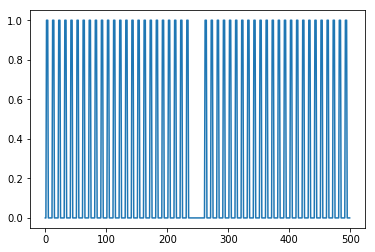

In [24]:
a[attributes.modality != 'n'] = 1
plt.plot(a)

## Load the subject's functional data (along with whole brain mask)

In [11]:
import nilearn as nl
import nibabel as nib

In [17]:
subj_dataDir = join(dataDir, subj)
bold_file = join(subj_dataDir, 'preprocessing.feat', 'filtered_func_data.nii.gz')
mask_file = join(subj_dataDir, 'masks/TDSL2_brain_mask.nii.gz')

In [13]:
# create a Nilearn Masker...this will convert the dataset to a 2D array
# as well as standardize the voxel timeseries
from nilearn.input_data import NiftiMasker

In [18]:
masker = NiftiMasker(mask_img=mask_file, standardize=True)
fmri_masked = masker.fit_transform(bold_file)
fmri_masked.shape

(500, 25182)